# Test of class Hamiltonian_QED

In [1]:
import qiskit

In [2]:
qiskit.__version__

'0.24.1'

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from scipy.sparse.linalg import eigsh
from qiskit.quantum_info import Statevector
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../") # go to parent dir
from itertools import permutations,product
from tqdm.notebook import tqdm

In [5]:
from Hamiltonian_QED_sym import HamiltonianQED_sym
from Hamiltonian_QED_oprt import HamiltonianQED_oprt
from HC_Lattice import HCLattice
import primme

/var/folders/08/fx8gnyrx18jggry6_s4cbtz40000gn/T/ipykernel_31435/3415147788.py:4: DeprecationWarning: Please use `aslinearoperator` from the `scipy.sparse.linalg` namespace, the `scipy.sparse.linalg.interface` namespace is deprecated.
  import primme


In [6]:
#Qiskit import
from qiskit import QuantumCircuit, QuantumRegister,ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram
from qiskit.circuit import Parameter
import qiskit.quantum_info as qinf
from qiskit.primitives import Sampler, Estimator
from qiskit.algorithms.state_fidelities import ComputeUncompute
from qiskit.quantum_info import SparsePauliOp, Pauli, Operator
from sys import stdout
from qiskit.algorithms.optimizers import NFT,SLSQP,COBYLA,ADAM,SPSA,QNSPSA
from qiskit.quantum_info.states import DensityMatrix
import qiskit.quantum_info as qinf
from qiskit.quantum_info import entropy


##### Quantum circuit

In [7]:
def gray_code_lim(l,theta=None,layers=1):
    """Return Gray code circuit for gauge field and truncation l=1,2,3,6,7,15."""
    if l not in [1,2,3,6,7,15]:
        raise ValueError('l must be 1,2,3,6,7,15')
    n_qubits =int(np.ceil(np.log2(2 * l+ 1)))
    qc = QuantumCircuit(n_qubits)
    params = lambda i: Parameter(f'theta_{i}')

    if theta is None:
        t=0
    else:
        t=theta

    #First layer of ry gates
    for j in range(layers):
        for i in range(n_qubits-1):
            qc.ry(params(t),i)
            t+=1
        
    if l==2:
        for j in range(layers):
            qc.x(0)
            qc.mcry(params(t),list(range(n_qubits-1)),n_qubits-1,use_basis_gates=True)
            qc.x(0)
            t+=1

    else:
        #1st cry gate 
        for j in range(layers):
            qc.cry(params(t),n_qubits-2,n_qubits-1)
            t+=1

        if l==6:
            for j in range(layers):
                qc.x(0)
                qc.x(2)
                qc.mcry(params(t),list(range(n_qubits-1)),n_qubits-1,use_basis_gates=True)
                qc.x(0)
                qc.x(2)
                t+=1

        #2nd cry gate
        if l>1 and l!=6:
            for j in range(layers):
                qc.cry(params(t),n_qubits-3,n_qubits-1)
                t+=1

            # if l==14:#TODO see why qiskit error 
            #     qc.x(0)
            #     qc.x(2)
            #     qc.x(3)
            #     #qc.mcry(params(t),list(range(n_qubits-1)),n_qubits-1,use_basis_gates=True)
            #     qc.x(0)
            #     qc.x(2)
            #     qc.x(3)
            #     t+=1

            #layers of cry gates if l>3
            if l>3 and l!=14:
                for j in range(layers):
                    for i in range(1,n_qubits-2)[::-1]:
                        qc.cry(params(t),i-1,i)
                        t+=1

    par_list = [params(i) for i in range(t)]

    return qc,par_list

##### Quantum ansatz test

In [8]:
for l in range(1,16):
    print('unphys stases for l=',l,':',2**int(np.ceil(np.log2(2 * l+ 1)))-(2 * l + 1))

unphys stases for l= 1 : 1
unphys stases for l= 2 : 3
unphys stases for l= 3 : 1
unphys stases for l= 4 : 7
unphys stases for l= 5 : 5
unphys stases for l= 6 : 3
unphys stases for l= 7 : 1
unphys stases for l= 8 : 15
unphys stases for l= 9 : 13
unphys stases for l= 10 : 11
unphys stases for l= 11 : 9
unphys stases for l= 12 : 7
unphys stases for l= 13 : 5
unphys stases for l= 14 : 3
unphys stases for l= 15 : 1


In [9]:
l=3
print('unphys stases for l=',l,':',2**int(np.ceil(np.log2(2 * l+ 1)))-(2 * l + 1))
for i in range(0, 2 * l + 1):
    gray_decimal = i ^ (i >> 1)
    print( "{0:0{1}b}".format(gray_decimal,int(np.ceil(np.log2(2 * l+ 1)))))

unphys stases for l= 3 : 1
000
001
011
010
110
111
101


In [10]:
#unphys states
for i in range(2 * l + 1, 2**int(np.ceil(np.log2(2 * l+ 1)))):
    gray_decimal = i ^ (i >> 1)
    print( "{0:0{1}b}".format(gray_decimal,int(np.ceil(np.log2(2 * l+ 1)))))

100


In [11]:

for i in range(0, 2**int(np.ceil(np.log2(2 * l+ 1)))):
    gray_decimal = i ^ (i >> 1)
    print( "{0:0{1}b}".format(gray_decimal,int(np.ceil(np.log2(2 * l+ 1)))))

000
001
011
010
110
111
101
100


In [69]:
def circuit_physical(qc_test,n_qubits,th,fermions=False):
    """Test with a range of values for the parameters of the circuit qc_test
    if it reaches all and only physical states of Gray encoding or fermions with zero charge if fermions=True, i.e. same n.er of 0 and 1."""

    #sampler = Sampler()
    if fermions:
        theta_values_0 = np.linspace(0, np.pi/2, 2)  # Parameter values 0=gate doesn't act or pi/2=gate acts RXX+RYY
    else:
        theta_values_0 = np.linspace(0, np.pi, 2) # Parameter values 0=gate doesn't act or pi=gate acts RY(theta)=exp(-i *theta *Y/2)

    params = lambda i: Parameter(f'theta_{i}')
    par_list = [params(i) for i in range(th)]

    states_reached = set()
    for theta in tqdm(list(product(theta_values_0, repeat=len(par_list)))):
        bound_qc =qc_test.bind_parameters(dict(zip(qc_test.parameters,theta)))
        result = Statevector(bound_qc).probabilities_dict()
        
        # tmp = bound_qc.copy()
        # tmp.measure_all()
        # res = sampler.run(tmp).result() 
        
        # result={x:round(y,6) for x,y in res.quasi_dists[0].binary_probabilities().items() if y>1e-16}
        # tmp.remove_final_measurements()

        # #print('theta=',theta,result)

        for k in [key for key, value in result.items() if value >1e-16]:#consider nonzero probabilities
            if k not in states_reached:
                states_reached.add(k)
                
     
    if fermions:
        #check if only state with same n.er of 0 and 1 are reached
        ferm_q0 = {''.join(i) for i in permutations(['0','1']*(n_qubits//2),n_qubits)}
        if n_qubits<8:
            print(f"{len(states_reached)} states reached:",states_reached,f'{len(ferm_q0)} fermions with zero charge:',ferm_q0)
        if states_reached==ferm_q0:   
            print('all physical states reached : OK!')
        else:
            print('not all physical states reached')

    else:
        gray_unph = set()
        for i in range(2 * l + 1, 2**int(np.ceil(np.log2(2 * l+ 1)))):
            gray_decimal = i ^ (i >> 1)
            gray_unph.add("{0:0{1}b}".format(gray_decimal,int(np.ceil(np.log2(2 * l+ 1))))) 

        gray_phys = set()
        for i in range(0, 2 * l + 1):
            gray_decimal = i ^ (i >> 1)
            gray_phys.add("{0:0{1}b}".format(gray_decimal,int(np.ceil(np.log2(2 * l+ 1)))))

        if n_qubits<8:
            print('states reached:',states_reached,'states unphys:',gray_unph,'states phys:',gray_phys)
        if states_reached==gray_phys:
            print('all physical states reached : OK!')
        else:
            print('not all physical states reached')

GRAY ENCODING 

In [70]:
#Tested for l=1,2,3,6,7,15
l_list_test = [1,2,3,6,7,15]

for l in l_list_test:
    print('l=',l)
    n_qubits =int(np.ceil(np.log2(2 * l+ 1)))
    qc_test,par_list = gray_code_lim(l)

    #qc_test.draw('mpl')#,filename='gray_code_lim_l1.png')

    circuit_physical(qc_test,n_qubits,len(par_list),fermions=False)

l= 1


  0%|          | 0/4 [00:00<?, ?it/s]

states reached: {'00', '01', '11'} states unphys: {'10'} states phys: {'00', '01', '11'}
all physical states reached : OK!
l= 2


  0%|          | 0/8 [00:00<?, ?it/s]

states reached: {'110', '001', '011', '000', '010'} states unphys: {'100', '111', '101'} states phys: {'110', '001', '011', '000', '010'}
all physical states reached : OK!
l= 3


  0%|          | 0/16 [00:00<?, ?it/s]

states reached: {'110', '001', '011', '101', '000', '010', '111'} states unphys: {'100'} states phys: {'110', '001', '011', '000', '101', '010', '111'}
all physical states reached : OK!
l= 6


  0%|          | 0/32 [00:00<?, ?it/s]

states reached: {'0101', '1111', '0111', '0000', '1100', '0001', '1010', '1101', '0110', '0100', '1110', '0010', '0011'} states unphys: {'1001', '1000', '1011'} states phys: {'0101', '1111', '0111', '0000', '1100', '0001', '1010', '1101', '0110', '0100', '1110', '0010', '0011'}
all physical states reached : OK!
l= 7


  0%|          | 0/64 [00:00<?, ?it/s]

states reached: {'0101', '1111', '1011', '0111', '0000', '1100', '1001', '0001', '1010', '1101', '0110', '0100', '1110', '0010', '0011'} states unphys: {'1000'} states phys: {'0101', '1111', '1011', '0111', '0000', '1100', '1001', '0001', '1010', '1101', '0110', '0100', '1110', '0010', '0011'}
all physical states reached : OK!
l= 15


  0%|          | 0/256 [00:00<?, ?it/s]

states reached: {'01001', '00101', '01110', '00011', '11000', '11001', '11110', '01011', '00111', '10100', '11100', '10010', '01010', '10111', '00110', '00100', '10110', '00001', '10101', '11011', '11111', '01000', '01111', '00010', '11010', '11101', '10001', '00000', '01100', '10011', '01101'} states unphys: {'10000'} states phys: {'01001', '00101', '01110', '00011', '11000', '11001', '11110', '01011', '00111', '10100', '11100', '10010', '01010', '10111', '00110', '00100', '10110', '00001', '10101', '11011', '11111', '01000', '01111', '00010', '11010', '11101', '10001', '00000', '01100', '10011', '01101'}
all physical states reached : OK!


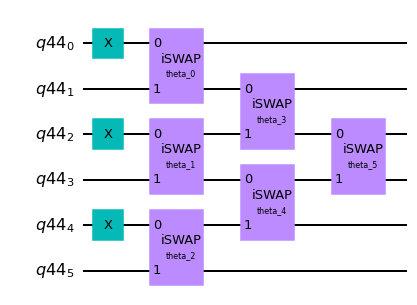

In [145]:
#fermion circuit proposal
p = Parameter('p')
qc = QuantumCircuit(2,name='iSWAP')
qc.rxx(p, 0, 1)
qc.ryy(p, 0, 1)


n_qubits_f = 6
qr = QuantumRegister(n_qubits_f)
qc_tot2 = QuantumCircuit(qr)

params = lambda i: Parameter(f'theta_{i}')

th=0
for i in range(0,n_qubits_f,2):
    qc_tot2.x(i)

for j in range(n_qubits_f//2):
    for i in range(j,n_qubits_f-j,2):
            qc_tot2.append(qc.to_instruction({p: params(th)}), qr[i:i+2])
            th+=1


qc_tot2.draw('mpl')

In [67]:
circuit_physical(qc_tot2,n_qubits_f,th,fermions=True)

  0%|          | 0/2097152 [00:00<?, ?it/s]

all physical states reached : OK!


In [68]:
print('n_qubits_f=',n_qubits_f)

n_qubits_f= 12


ZERO TOTAL CHARGE FOR FERMIONS WITH ISWAP GATES

In [ ]:
#TODO test 12 and 14 qubits

In [71]:
#Tested for up to 12 fermions. Parameter values 0=gate doesn't act or pi/2=gate acts RXX+RYY

n_qubits_f_list = range(2,12,2)
for n_qubits_f in n_qubits_f_list:
    print('n_qubits_f=',n_qubits_f)
    p = Parameter('p')
    qc = QuantumCircuit(2,name='iSWAP')
    qc.rxx(p, 0, 1)
    qc.ryy(p, 0, 1)

    qr = QuantumRegister(n_qubits_f)
    qc_tot2 = QuantumCircuit(qr)
    params = lambda i: Parameter(f'theta_{i}')

    th=0
    for i in range(0,n_qubits_f,2):
        qc_tot2.x(i)

    for j in range(n_qubits_f//2):
        for i in range(j,n_qubits_f-j,2):
                qc_tot2.append(qc.to_instruction({p: params(th)}), qr[i:i+2])
                th+=1

    circuit_physical(qc_tot2,n_qubits_f,th,fermions=True)

n_qubits_f= 2


  0%|          | 0/2 [00:00<?, ?it/s]

2 states reached: {'01', '10'} 2 fermions with zero charge: {'01', '10'}
all physical states reached : OK!
n_qubits_f= 4


  0%|          | 0/8 [00:00<?, ?it/s]

6 states reached: {'0101', '1100', '1001', '1010', '0110', '0011'} 6 fermions with zero charge: {'0101', '1100', '1001', '1010', '0110', '0011'}
all physical states reached : OK!
n_qubits_f= 6


  0%|          | 0/64 [00:00<?, ?it/s]

20 states reached: {'000111', '001101', '011100', '101010', '010101', '101001', '110100', '001110', '011010', '110010', '110001', '011001', '101100', '111000', '100011', '100101', '100110', '001011', '010011', '010110'} 20 fermions with zero charge: {'000111', '001101', '011100', '101010', '010101', '101001', '110100', '001110', '011010', '110010', '110001', '011001', '101100', '111000', '100011', '100101', '100110', '001011', '010011', '010110'}
all physical states reached : OK!
n_qubits_f= 8


  0%|          | 0/1024 [00:00<?, ?it/s]

all physical states reached : OK!
n_qubits_f= 10


  0%|          | 0/32768 [00:00<?, ?it/s]

all physical states reached : OK!


In [ ]:
#TODO: put layer of RZ (for fermions)?

##### Hamiltonian

In [291]:
#class input parameters:
n_sites = [4,1,]#how many sites for every dimension
g=5
fact_e_op = 1
fact_b_op = 1
m=3
omega=1
l=1
L=2
rotors = False
lambd = 1000
encoding = 'gray' ##'ed'#
magnetic_basis=False
pbc=False
puregauge = False 
static_charges_values =None#{(0,0):1,(1,0):-1}#TODO: no conditions applied, like charge conservation, etc. For conditions see func_qstatic_dist
display_hamiltonian=False
e_op_out_plus=False #if E out of site n has plus sign 
sparse_pauli =False #false for circuit ansatz
#exact diagonalisation parameters:
threshold = 1e-12
num_eigs = 2

In [292]:
latt = HCLattice(n_sites,pbc=pbc)

In [293]:
hamilt_sym = HamiltonianQED_sym(
                        latt,
                        n_sites,
                        l,
                        ll=L,
                        encoding = encoding,
                        rotors=rotors,
                        magnetic_basis=magnetic_basis,
                        pbc=pbc,
                        puregauge=puregauge,
                        static_charges_values=static_charges_values,
                        e_op_out_plus = e_op_out_plus,
                        display_hamiltonian=display_hamiltonian)

class_H_oprt = HamiltonianQED_oprt(
                        latt,
                        hamilt_sym,
                        n_sites,
                        l,
                        ll=L,
                        encoding = encoding,
                        rotors=rotors,
                        magnetic_basis=magnetic_basis,
                        pbc=pbc,
                        puregauge=puregauge,
                        static_charges_values=static_charges_values,
                        e_op_out_plus = e_op_out_plus,
                        sparse_pauli=sparse_pauli)

HamiltonianQED_sym: Initializing...
> Gauss law equations solved
> e_op_free and u_op_free built
>> Gauss law applied and Hamiltonian built.  Execution time: 0.026719093322753906 seconds
HamiltonianQED_oprt: Initializing...
> e_op_free and u_op_free built
> Pauli strings built
>> Hamiltonian built.  Execution time: 2.4655468463897705 seconds
>> Suppression term built.  Execution time: 0.002529144287109375 seconds


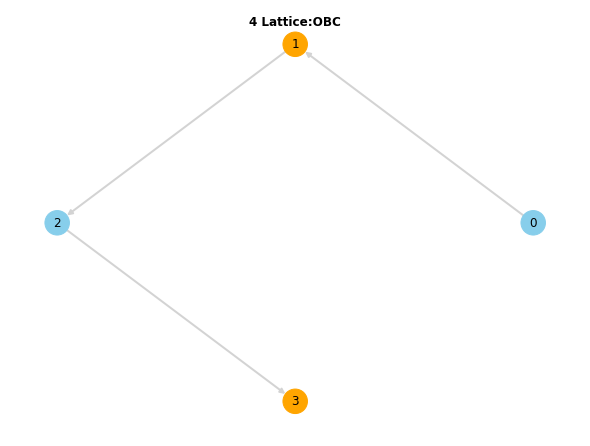

In [294]:

#latt.draw_graph_func(gauss_law_fig=False,static_charges=static_charges_values)
#only dynamical fields after Gauss law applied
latt.draw_graph_func(gauss_law_fig=True,e_op_free=class_H_oprt.e_op_free)#,savefig_dir='.')

In [295]:
class_H_oprt.uop_list#order of operators in tensor product and on circuit

[]

##### Test composite circuit

In [297]:
# #ansatz no entanglement
# nlayers = 1#TODO ATTENTION: selection of only physical states work only for nlayers=1
# ngauge = class_H_oprt.len_e_op
# nsites = 0#TODO add fermionic part
# n_qubits =int(np.ceil(np.log2(2 * l+ 1)))
# qc_tot = QuantumCircuit(n_qubits*ngauge+nsites)


# th=0
# #first gauge field
# qcc,lst = gray_code_lim(l,theta=th,layers=nlayers)
# qc_tot.compose(qcc,list(range(n_qubits)),inplace=True)

# for i in range(1,ngauge):#for the other gauge fields
#     theta = int(''.join(list(filter(str.isdigit, str(lst[-1])))))
#     qcc,lst = gray_code_lim(l,theta=theta+1,layers=nlayers)
#     qc_tot.compose(qcc,list(range(n_qubits*i,n_qubits*(i+1))),inplace=True)

# th=int(''.join(list(filter(str.isdigit, str(lst[-1])))))+1
# qc_tot.barrier()

# #**entanglement**
# #between the gauge fields
# # for i in range(n_qubits):
# #     for j in range(n_qubits,n_qubits*ngauge):
# #         qc_tot.cx(i,j)

# #linear entanglement cx gates
# # for i in range(n_qubits*ngauge-1):
# #     qc_tot.cx(i,i+1)


# #full entanglement cx gates
# # for i in range(n_qubits*ngauge):
# #     for j in range(i+1,n_qubits*ngauge):
# #         qc_tot.cx(i,j)

# #qc_tot.draw('mpl')#,filename='gray_code_lim_l1.png')

In [299]:
ngauge

0

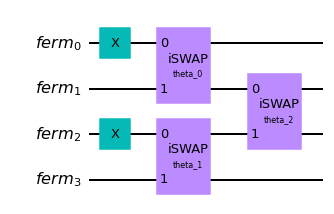

In [300]:
#ansatz full entanglement
nlayers = 1#TODO option more layers?
ngauge = class_H_oprt.len_e_op
if puregauge:
    n_qubits_f = 0
else:
    n_qubits_f = np.prod(latt.n_sites)#TODO add fermionic part

n_qubits =int(np.ceil(np.log2(2 * l+ 1)))

qferm = QuantumRegister(n_qubits_f,name='ferm')
qgaug = QuantumRegister(n_qubits*ngauge,name='gaug')
qc_tot2 = QuantumCircuit(qgaug,qferm)

th=0
#gauge part
if ngauge:
    qcc,lst = gray_code_lim(l,theta=th,layers=nlayers)
    #first gauge field
    qc_tot2.compose(qcc,list(range(n_qubits)),inplace=True)
    qc_tot2.barrier()
    th=int(''.join(list(filter(str.isdigit, str(lst[-1])))))+1

    for i in range(1,ngauge):
        qc_tot2.ry(Parameter(f'theta_{th}'),n_qubits*i)
        th+=1
        for j in range(n_qubits*i):
            qc_tot2.cry(Parameter(f'theta_{th}'),j,n_qubits*i)
            th+=1
        qc_tot2.barrier()
        qc_tot2.cry(Parameter(f'theta_{th}'),n_qubits*i,n_qubits*i+1)
        th+=1
        qc_tot2.barrier()
        #multi-controlled gates
        for j in range(n_qubits*i):
            qc_tot2.mcry(Parameter(f'theta_{th}'),[j,n_qubits*i],n_qubits*i+1)
            th+=1

#fermion circuit proposal
p = Parameter('p')
qc = QuantumCircuit(2,name='iSWAP')
qc.rxx(p, 0, 1)
qc.ryy(p, 0, 1)



params = lambda i: Parameter(f'theta_{i}')

#th=0
for i in range(0,n_qubits_f,2):
    qc_tot2.x(qferm[i])

for j in range(n_qubits_f//2):
    for i in range(j,n_qubits_f-j,2):
            qc_tot2.append(qc.to_instruction({p: params(th)}), qferm[i:i+2])
            th+=1

qc_tot2.draw('mpl')#,filename='gray_code_lim_l1.png')
#qc_tot2.decompose().draw('mpl')

In [140]:
#TODO: CTRL iSWAP for entanglements with gauge fields

In [100]:
qc_tot2.depth()

5

In [101]:
# #ansatz
# nlayers = 1#TODO ATTENTION: selection of only physical states work only for nlayers=1
# ngauge = class_H_oprt.len_e_op
# nsites = 0#TODO add fermionic part
# n_qubits =int(np.ceil(np.log2(2 * l+ 1)))
# qc_tot2 = QuantumCircuit(n_qubits*ngauge+nsites)

# th=0
# #first gauge field
# qcc,lst = gray_code_lim(l,theta=th,layers=nlayers)
# qc_tot2.compose(qcc,list(range(n_qubits)),inplace=True)


# th=int(''.join(list(filter(str.isdigit, str(lst[-1])))))
# qcc,lst = gray_code_lim(l,theta=th+1,layers=nlayers)
# qc_tot2.compose(qcc,list(range(4,6)),inplace=True)

# qc_tot2.barrier()
# th=int(''.join(list(filter(str.isdigit, str(lst[-1])))))
# qc_tot2.ry(Parameter(f'theta_{th+1}'),2)
# qc_tot2.cry(Parameter(f'theta_{th+2}'),0,2)
# qc_tot2.cry(Parameter(f'theta_{th+3}'),1,2)
# qc_tot2.cry(Parameter(f'theta_{th+4}'),4,2)
# qc_tot2.cry(Parameter(f'theta_{th+5}'),5,2)
# qc_tot2.barrier()

# qc_tot2.cry(Parameter(f'theta_{th+6}'),2,3)
# qc_tot2.mcry(Parameter(f'theta_{th+7}'),[0,2],3)
# qc_tot2.mcry(Parameter(f'theta_{th+8}'),[1,2],3)
# qc_tot2.mcry(Parameter(f'theta_{th+9}'),[4,2],3)
# qc_tot2.mcry(Parameter(f'theta_{th+10}'),[5,2],3)


# qc_tot2.draw('mpl')#,filename='gray_code_lim_l1.png')

In [301]:
def fidelity_func(myvqd_results2,eigenvectors_matrix,num_eigs):

    """ Inputs; results from VQD and eigenvector matrix from ED. Update to Qiskit version 0.24.1"""
    
    vqd_states = [myvqd_results2.optimal_circuits[i].bind_parameters(myvqd_results2.optimal_parameters[i].values()) for i in range(num_eigs)]

    vqd_fid_states =[qinf.Statevector.from_instruction(i) for i in vqd_states]
    ed_fid_states =[Statevector(eigenvectors_matrix[:,i]) for i in range(num_eigs)]

    return [qinf.state_fidelity(vqd,ed) for vqd,ed in zip(vqd_fid_states,ed_fid_states)]

2D_2x2mbasisFalse puregaugeTrue g0.1 pbcTrue l1_factE1_factB1_m3_Omega1 nlayers1 iterations[500, 500] optimizerSLSQP:

in. point

array([ 0.2018109 ,  0.24488692,  0.21166536,  0.2827267 ,  0.57939206,
        0.0510488 , -0.60911057,  0.58872647, -0.59156033,  0.63703664,
        0.6161558 ,  0.32709866, -0.14901505,  0.25207003, -0.59671775,
        0.55807236,  0.17197293, -0.29482396, -0.71963126, -0.48101984,
        0.69696426,  0.21615586,  0.19234214, -0.71834603, -0.75412552,
       -0.51238705, -0.35319082,  0.35969965, -0.39224147,  0.48351348,
        0.40515203, -0.52143608,  0.15010049, -0.62242227, -0.49699271,
       -0.66024822, -0.74409014, -0.34114466,  0.49847996, -0.47393087,
       -0.38242287,  0.06001916,  0.5692371 , -0.00607085, -0.00131586,
        0.55668509,  0.24684299, -0.50486786,  0.38434161, -0.29313127])

In [302]:
initial_point=np.array([ 0.2018109 ,  0.24488692,  0.21166536,  0.2827267 ,  0.57939206,
        0.0510488 , -0.60911057,  0.58872647, -0.59156033,  0.63703664,
        0.6161558 ,  0.32709866, -0.14901505,  0.25207003, -0.59671775,
        0.55807236,  0.17197293, -0.29482396, -0.71963126, -0.48101984,
        0.69696426,  0.21615586,  0.19234214, -0.71834603, -0.75412552,
       -0.51238705, -0.35319082,  0.35969965, -0.39224147,  0.48351348,
        0.40515203, -0.52143608,  0.15010049, -0.62242227, -0.49699271,
       -0.66024822, -0.74409014, -0.34114466,  0.49847996, -0.47393087,
       -0.38242287,  0.06001916,  0.5692371 , -0.00607085, -0.00131586,
        0.55668509,  0.24684299, -0.50486786,  0.38434161, -0.29313127])

#test con 5 itrs per E0, initial point=[best parameters di E0, random per E1] visto che ok risultato. improvement for E1
initial_point=np.array([ 3.14154162e+00,  5.72623979e-04,  2.17575153e-01, -4.43899343e+00,
       -2.52326329e-02, -8.52384728e-01,  9.72301363e-01,  2.53065378e-01,
       -1.19903100e-01, -3.68589042e-01, -4.41354980e+00,  9.60270708e-01,
       -3.34982139e-01,  3.80935810e-01, -8.61384447e-01, -4.69209243e-01,
        1.17306594e+00,  3.26564763e-01,  4.72398075e-01, -3.80842210e-01,
        4.03939615e-01, -4.44077834e-02, -7.74449354e-01, -2.80660656e+00,
       -4.71371794e-02, -3.93666626e-01,  5.00971380e+00, -2.47171242e-01,
       -2.80326076e-01, -1.60553159e+00,  2.25608451e-01, -1.15995150e+00,
       -8.50900211e-01,  1.14454655e+00,  3.60792093e-01,  6.70696852e-02,
       -1.10024490e+00, -1.54467799e-01,  1.65335541e-01,  1.13584008e+00,
       -4.67075197e-01,  4.10233323e-01,  4.18324225e-01, -2.91362996e-01,
       -2.09179246e-01,  3.83636545e-02, -3.83597141e-02,  4.95250596e-01,
        3.30578886e+00, -2.00839239e+00])

In [303]:
initial_point=np.array([ 3.14154162e+00,  5.72623979e-04,  2.17575153e-01, -4.43899343e+00,
       -2.52326329e-02, -8.52384728e-01,  9.72301363e-01,  2.53065378e-01,
       -1.19903100e-01, -3.68589042e-01, -4.41354980e+00,  9.60270708e-01,
       -3.34982139e-01,  3.80935810e-01, -8.61384447e-01, -4.69209243e-01,
        1.17306594e+00,  3.26564763e-01,  4.72398075e-01, -3.80842210e-01,
        4.03939615e-01, -4.44077834e-02, -7.74449354e-01, -2.80660656e+00,
       -4.71371794e-02, -3.93666626e-01,  5.00971380e+00, -2.47171242e-01,
       -2.80326076e-01, -1.60553159e+00,  2.25608451e-01, -1.15995150e+00,
       -8.50900211e-01,  1.14454655e+00,  3.60792093e-01,  6.70696852e-02,
       -1.10024490e+00, -1.54467799e-01,  1.65335541e-01,  1.13584008e+00,
       -4.67075197e-01,  4.10233323e-01,  4.18324225e-01, -2.91362996e-01,
       -2.09179246e-01,  3.83636545e-02, -3.83597141e-02,  4.95250596e-01,
        3.30578886e+00, -2.00839239e+00])

In [321]:
#Input parameters for VQD
estimator = Estimator()
sampler = Sampler()
fidelity = ComputeUncompute(sampler)

iterations = [500 for i in range(num_eigs)]
#iterations= [5,500]
optimizer = [SLSQP(maxiter=itr) for itr in iterations] #SLSQP,COBYLA 
ansatz = qc_tot2
betas = [20,]*(num_eigs-1)#[4,0.5]#[5,]*(num_eigs-1)   #***default value computed as the mean square sum of the coefficients of the observable.
val_init = np.pi/4

#initial_point=[val_init*(2*np.random.rand(ansatz.num_parameters)-1.0) for kkk in range(num_eigs)]
initial_point=val_init*(2*np.random.rand(ansatz.num_parameters)-1.0) 

aux_operators =[class_H_oprt.hamiltonian_mag_pauli,] if ngauge else None

Hamiltonian_Pauli_tot_vqd = class_H_oprt.get_hamiltonian(g_var=g, m_var=m, omega=omega,fact_b_op=fact_b_op,fact_e_op=fact_b_op,lambd=0)

In [322]:
#initial_point = [np.array(list(result.optimal_parameters[0].values())),val_init*(2*np.random.rand(ansatz.num_parameters)-1.0) ]

In [323]:
#ED
import scipy.sparse as sp
Hamiltonian_Pauli_tot = class_H_oprt.get_hamiltonian(g_var=g, m_var=m, omega=omega,fact_b_op=fact_b_op,fact_e_op=fact_b_op,lambd=lambd)
#memory sparse matrix
#print((Hamiltonian_Pauli_tot.data.nbytes + Hamiltonian_Pauli_tot.indptr.nbytes + Hamiltonian_Pauli_tot.indices.nbytes)/1000**3,'Gb')
if encoding=='gray' and not sparse_pauli:
    Hamiltonian_Pauli_tot = Hamiltonian_Pauli_tot.to_matrix(sparse=True)
    if ngauge:
        h_b_sparse = class_H_oprt.hamiltonian_mag_pauli.to_matrix(sparse=True) #plaquette
    else:
        h_b_sparse = 0 
elif encoding=='ed':
    Hamiltonian_Pauli_tot = sp.csr_matrix(Hamiltonian_Pauli_tot)
    if ngauge:
        h_b_sparse =sp.csr_matrix(class_H_oprt.hamiltonian_mag_pauli)
    else:
        h_b_sparse =0

#** Exact diagonalisation
spectrum, eigenvectors_matrix =primme.eigsh(Hamiltonian_Pauli_tot,k=num_eigs,which="SA")#,ncv = 30)
#spectrum
idx = spectrum.argsort() 
spectrum = spectrum[idx]
eigenvectors_matrix = eigenvectors_matrix[:,idx]
ed_val = []
for kk in range(num_eigs):
    ed_val.append(dict([(str(np.binary_repr(i, width = (ngauge*n_qubits+n_qubits_f))),np.abs(eigenvectors_matrix[:,kk][i])**2) for i in range(2**(ngauge*n_qubits+n_qubits_f)) if np.abs(eigenvectors_matrix[:,kk][i])**2>1e-10]))

eig0cj = sp.csr_matrix(eigenvectors_matrix[:,0]).transpose().conjugate()
eig0= sp.csr_matrix(eigenvectors_matrix[:,0])
if ngauge:
    plaq = (eig0*h_b_sparse*eig0cj/len(latt.plaq_list) ).toarray()[0][0].real

print('spectrum ED:',spectrum)

spectrum ED: [-6.12304375 -0.09129724]


entropy E_0
entropy E_1
circuits entropy


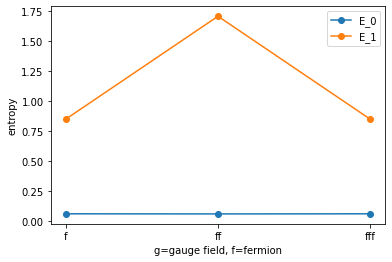

In [324]:
#****Entropy ED: between the gauge fields only (not internal qubits)
n_qubits_tot = ngauge*n_qubits+n_qubits_f
ntot_rev = list(range(n_qubits_tot))[::-1]

S_ed_list = []
for k in range(num_eigs):
    print(f'entropy E_{k}')
    s_tmp = []
    for i in range(ngauge-1):
        S_ed = entropy(qinf.partial_trace(DensityMatrix(eigenvectors_matrix[:,k]), ntot_rev[:(i+1)*n_qubits][::-1]))#list(range(0,(i+1)*n_qubits))))
        #print('A=',list(range(0,(i+1)*n_qubits)),'S=',S_ed)#'B=',list(range((i+1)*n_qubits,ngauge*n_qubits)),
        s_tmp.append(S_ed)
    if ngauge:
        start_f = ngauge*n_qubits
    else:
        start_f = 1
    for i in range(start_f,n_qubits_tot):
        S_ed = entropy(qinf.partial_trace(DensityMatrix(eigenvectors_matrix[:,k]),ntot_rev[:i][::-1]))# list(range(i))))
        #print('A=',list(range(i)),'S=',S_ed)#'B=',list(range((i+1)*n_qubits,ngauge*n_qubits)),
        s_tmp.append(S_ed)

    S_ed_list.append(s_tmp)
print('circuits entropy')
#circuit, tried with some values of thetas
# circ = qc_tot2
# for i in range(ngauge-1):
#     print('A=',list(range(0,(i+1)*n_qubits)),'B=',list(range((i+1)*n_qubits,ngauge*n_qubits)),'S=',
#             [np.round(entropy(qinf.partial_trace(DensityMatrix(circ.bind_parameters([np.pi/p]*circ.num_parameters )), list(range(0,(i+1)*n_qubits)))),5) for p in [0.25,0.5,1,2,4]])

from itertools import accumulate
custom_labels = ['g']*ngauge+['f']*(n_qubits_f-1)
custom_labels = [''.join(custom_labels[:i+1]) for i, _ in enumerate(accumulate(custom_labels))]
x_values = list(range(ngauge+n_qubits_f-1))
[plt.plot(val,marker='o',label=f'E_{j}') for j,val in enumerate(S_ed_list)]
plt.xticks(x_values, custom_labels)
plt.ylabel('entropy')
plt.xlabel('g=gauge field, f=fermion')
plt.legend()

In [326]:
from qiskit.algorithms.eigensolvers import VQD

#callback function
E_data = [[] for k in range(num_eigs)]
Fidelity = [[] for k in range(num_eigs)]
def callback(eval_count, parameters, mean, meta, step):
    stdout.write("eig: %d/%d -> its %4d/%d \r"%(step,num_eigs,eval_count,2*iterations[step-1]+51)) # assuming SPSA
    stdout.flush()

    #fidelity
    vqd_states = [ansatz.bind_parameters(parameters) for i in range(num_eigs)]
    vqd_fid_states =[qinf.Statevector.from_instruction(i) for i in vqd_states]
    ed_fid_states =[Statevector(eigenvectors_matrix[:,i]) for i in range(num_eigs)]
    Fidelity[step-1].append([qinf.state_fidelity(vqd,ed) for vqd,ed in zip(vqd_fid_states,ed_fid_states)])

    #energy
    E_data[step-1].append([len(E_data[step-1]),mean,meta])

#Perform VQD for Hamiltonian and plaquette operator
vqd = VQD(estimator, fidelity, ansatz, optimizer, k=num_eigs, betas=betas,initial_point=initial_point,  callback=callback)
result = vqd.compute_eigenvalues(operator = Hamiltonian_Pauli_tot_vqd,aux_operators = aux_operators)# Hamiltonian + auxiliary operator
vqd_values = result.eigenvalues

#eigenvectors
vqd2_eigenstates = []
for i in range(num_eigs):
    tmp = result.optimal_circuits[i].copy()
    
    tmp.measure_all()
    opt_pt =list(result.optimal_parameters[i].values())
    res = sampler.run(tmp, opt_pt).result() 
    
    vqd2_eigenstates.append({x:round(y,6) for x,y in res.quasi_dists[0].binary_probabilities().items() if y>0.0001})
    tmp.remove_final_measurements()

if ngauge:
    plaq_vqd = np.array(result.aux_operators_evaluated[0])[:,0][0]/len(latt.plaq_list)

In [327]:


print(f'E_i ED vs VQD test:{latt.dims}D_'+'x'.join(map(str,latt.n_sites))+f'mbasis{magnetic_basis} puregauge{puregauge} g{g} pbc{pbc} l{l}_factE{fact_e_op}_factB{fact_b_op}_m{m}_Omega{omega} nlayers{nlayers} iterations{iterations} optimizer'+
[i for i in ['NFT','SLSQP','COBYLA','ADAM','SPSA'] if i in str(optimizer[0])][0])

#** Print results
for kk,evalu in enumerate(spectrum):
        if evalu<900:# only physical states, 1000 corresponds to factor of penalty term
            print(f'E_{kk}(ED)=',round(evalu,8))#,[(str(np.binary_repr(i, width = (ngauge*n_qubits))),round(np.abs(eigenvectors_matrix[:,kk][i])**2,6)) for i in range(2**(ngauge*n_qubits)) if np.abs(eigenvectors_matrix[:,kk][i])**2>1e-4])
            print(f'E_{kk}(VQD)=',vqd_values.real[kk])#,vqd2_eigenstates[kk])

#** Plaquette operator
print('\n','Plaq. ED:',plaq,'Plaq. VQD:',plaq_vqd.real,'\n')
#** Fidelity final
fid=fidelity_func(result,eigenvectors_matrix,num_eigs)
                   

print('Fidelity (|psi_VQDXpsi_ED|^2):')
[print(f'E_{i}:',fd) for i,fd in enumerate(fid)]


#**Check if there are unphysical states
gray_unph = []
for i in range(2 * l + 1, 2**int(np.ceil(np.log2(2 * l+ 1)))):
    gray_decimal = i ^ (i >> 1)
    gray_unph.append("{0:0{1}b}".format(gray_decimal,int(np.ceil(np.log2(2 * l+ 1)))))  

ferm_q0 = [''.join(i) for i in permutations(['0','1']*(n_qubits//2),n_qubits)]

print('Check if in VQD sol. there are unphysical states: Gauge fields:',gray_unph,'Fermions: only zero charge are considered physical')
for i in range(num_eigs):
    if ngauge:
        for vqd_res in [string[-(ngauge*n_qubits):][i:i+int(np.ceil(np.log2(2 * l+ 1)))] for string in vqd2_eigenstates[i].keys() for i in range(0, len(string[-(ngauge*n_qubits):]), int(np.ceil(np.log2(2 * l+ 1))))]:
            if vqd_res in gray_unph:
                print('unphysical state reached for gauge fields')
                break
        else:   
            print(f'E_{i} all physical states reached gauge fields: OK!')
    if n_qubits_f:
        for vqd_res in [string[:n_qubits_f] for string in vqd2_eigenstates[i].keys() ]:

            if vqd_res in ferm_q0:
                print('unphysical state reached for fermions')
                break
        else:   
            print(f'E_{i} all physical states reached fermions: OK!')


E_i ED vs VQD test:1D_4mbasisFalse puregaugeFalse g5 pbcFalse l1_factE1_factB1_m3_Omega1 nlayers1 iterations[500, 500] optimizerSLSQP
E_0(ED)= -6.12304375
E_0(VQD)= -5.999999954827834
E_1(ED)= -0.09129724
E_1(VQD)= 3.796795282653576e-08

 Plaq. ED: 0.0008018049316592887 Plaq. VQD: nan 

Fidelity (|psi_VQDXpsi_ED|^2):
E_0: 0.9801680842944613
E_1: 0.038223703197391164
Check if in VQD sol. there are unphysical states: Gauge fields: ['10'] Fermions: only zero charge are considered physical
E_0 all physical states reached fermions: OK!
E_1 all physical states reached fermions: OK!


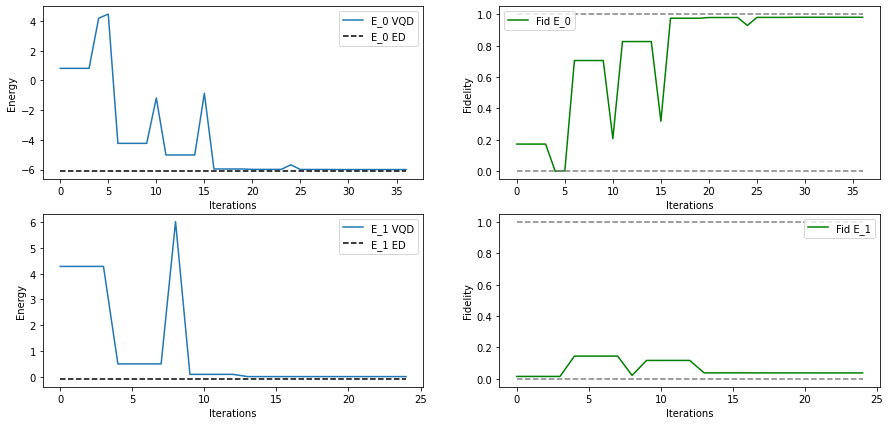

In [328]:
fig,axes = plt.subplots(num_eigs,2,figsize=(15,7))

for k in range(num_eigs):
    #Energy
    axes[k][0].plot([i[0] for i in E_data[k]],[i[1] for i in E_data[k]],label=f'E_{k} VQD')
    axes[k][0].hlines(spectrum[k],0,E_data[k][-1][0],linestyles='dashed',color='black',label=f'E_{k} ED')

    #Fidelity
    axes[k][1].plot([i[0] for i in E_data[k]],[i[k] for i in Fidelity[k]],label=f'Fid E_{k}',color='green')
    #fidelity max value 1 and min 0
    axes[k][1].hlines(1,0,E_data[k][-1][0],linestyles='dashed',color='gray')
    axes[k][1].hlines(0,0,E_data[k][-1][0],linestyles='dashed',color='gray')

    axes[k][0].set_ylabel('Energy')
    axes[k][1].set_ylabel('Fidelity')

    for i in range(2):
        axes[k][i].set_xlabel('Iterations')
        axes[k][i].legend()

#fig.savefig('ansatz_tests/'+f'Energy_Fidelity_ED_vs_VQD_test:{latt.dims}D_'+'x'.join(map(str,latt.n_sites))+f'mbasis{magnetic_basis}_puregauge{puregauge}_g{g}_pbc{pbc}_l{l}_nlayers{nlayers}_iterations{iterations}.png')

##### Histograms

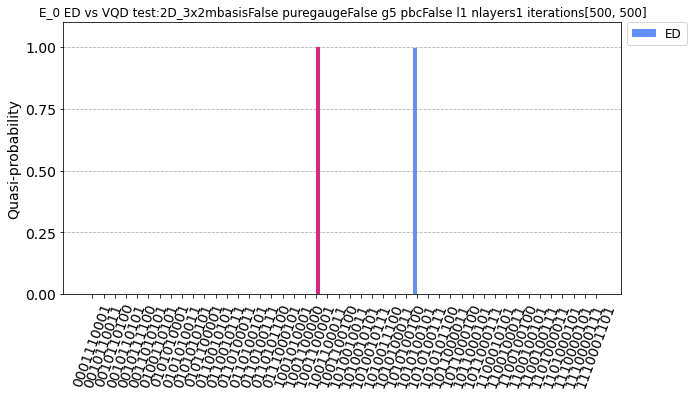

In [267]:
from qiskit.visualization import plot_histogram
plot_histogram([ed_val[0],vqd2_eigenstates[0]], figsize=(10,5),legend=['ED','VQD'] ,bar_labels=False,
               title=f'E_0 ED vs VQD test:{latt.dims}D_'+'x'.join(map(str,latt.n_sites))+f'mbasis{magnetic_basis} puregauge{puregauge} g{g} pbc{pbc} l{l} nlayers{nlayers} iterations{iterations}')
               #,filename='ansatz_tests/'+f'E_0_ED_vs_VQD_test:{latt.dims}D_'+'x'.join(map(str,latt.n_sites))+f'mbasis{magnetic_basis}_puregauge{puregauge}_g{g}_pbc{pbc}_l{l}_nlayers{nlayers}_iterations{iterations}')


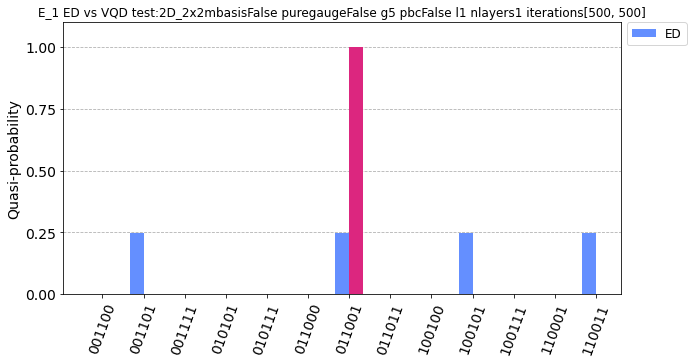

In [128]:
plot_histogram([ed_val[1],vqd2_eigenstates[1]], figsize=(10,5),legend=['ED','VQD'] ,bar_labels=False,
               title=f'E_1 ED vs VQD test:{latt.dims}D_'+'x'.join(map(str,latt.n_sites))+f'mbasis{magnetic_basis} puregauge{puregauge} g{g} pbc{pbc} l{l} nlayers{nlayers} iterations{iterations}')
               #,filename='ansatz_tests/'+f'E_1_ED_vs_VQD_test:{latt.dims}D_'+'x'.join(map(str,latt.n_sites))+f'mbasis{magnetic_basis}_puregauge{puregauge}_g{g}_pbc{pbc}_l{l}_nlayers{nlayers}_iterations{iterations}')